In [46]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [47]:
raw_dt = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2015-02-26 21:42:53,11
1,2015-02-26 21:47:53,10
2,2015-02-26 21:52:53,3
3,2015-02-26 21:57:53,4
4,2015-02-26 22:02:53,9


Text(0.5, 1.0, 'Original Dataset')

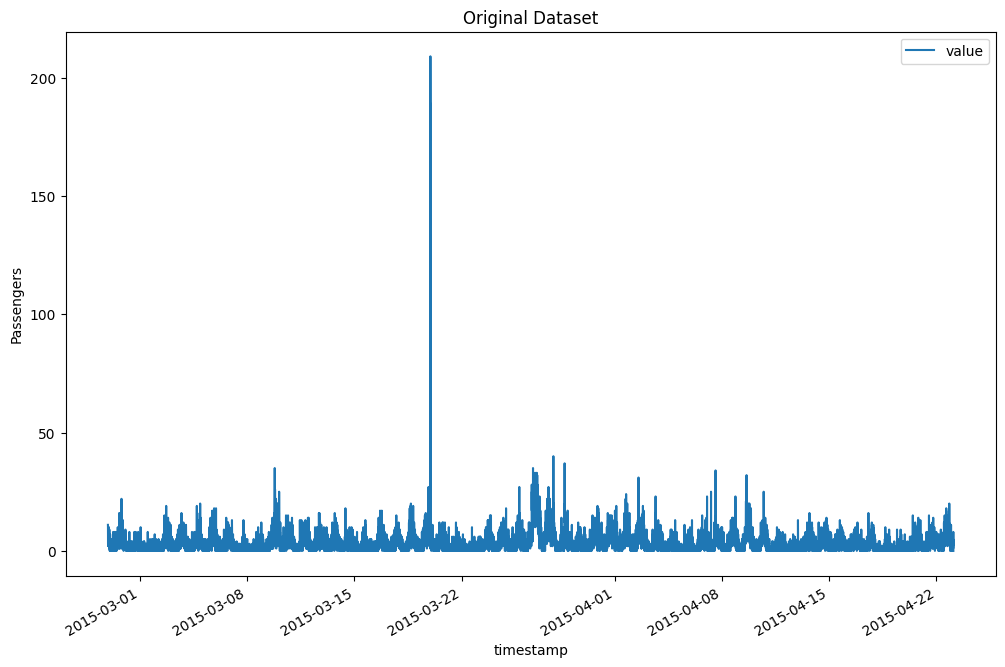

In [48]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("Passengers")
plt.title("Original Dataset")

In [49]:
data['label'] = 0
instances=[
        [
            "2015-03-08 21:02:53.000000",
            "2015-03-10 17:12:53.000000"
        ],
        [
            "2015-03-19 01:02:53.000000",
            "2015-03-20 21:12:53.000000"
        ],
        [
            "2015-03-25 21:02:53.000000",
            "2015-03-27 17:12:53.000000"
        ]
    ]

In [50]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1

In [51]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2015-02-26 21:42:53,11,0
1,2015-02-26 21:47:53,10,0
2,2015-02-26 21:52:53,3,0
3,2015-02-26 21:57:53,4,0
4,2015-02-26 22:02:53,9,0
...,...,...,...
15897,2015-04-23 02:27:53,1,0
15898,2015-04-23 02:32:53,4,0
15899,2015-04-23 02:37:53,3,0
15900,2015-04-23 02:42:53,8,0


In [52]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week
0,2015-02-26 21:42:53,11,0,26,2,21.700000,3
1,2015-02-26 21:47:53,10,0,26,2,21.783333,3
2,2015-02-26 21:52:53,3,0,26,2,21.866667,3
3,2015-02-26 21:57:53,4,0,26,2,21.950000,3
4,2015-02-26 22:02:53,9,0,26,2,22.033333,3


In [53]:
cont_vars = ['value', 'hour_min']
cat_vars = ['day', 'month', 'day_of_week']
data.drop('timestamp', axis=1, inplace=True)

In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,11,0,21.700000,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,10,0,21.783333,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,3,0,21.866667,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,4,0,21.950000,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,9,0,22.033333,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,1,0,2.450000,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,4,0,2.533333,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,3,0,2.616667,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,8,0,2.700000,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [55]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'day_0', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'month_0',
       'month_1', 'month_2', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')


In [56]:
# Splitting to train and test
test_ratio =0.6
tr_data = data.iloc[int(len(data) * test_ratio) :]
tst_data = data.iloc[: int(len(data) * test_ratio)]

In [57]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [58]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [59]:
tr_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
9541,-0.022741,0,-1.608309,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9542,0.280521,0,-1.596308,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9543,-0.629266,0,-1.584307,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9544,0.280521,0,-1.572307,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9545,0.887047,0,-1.560306,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,-0.629266,0,-1.368296,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,0.280521,0,-1.356295,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,-0.022741,0,-1.344295,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,1.493572,0,-1.332294,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [60]:
tst_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2.403359,0,1.403852,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,2.100097,0,1.415853,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,-0.022741,0,1.427854,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,0.280521,0,1.439854,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,1.796834,0,1.451855,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536,4.222935,0,-1.668312,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9537,3.919672,0,-1.656311,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9538,2.100097,0,-1.644311,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9539,1.796834,0,-1.632310,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False


In [61]:
train = tr_data_scaled[tr_data_scaled.label != 1]
train= train.drop(columns=['label'])
train

,value,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
9541,-0.022741,-1.608309,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9542,0.280521,-1.596308,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9543,-0.629266,-1.584307,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9544,0.280521,-1.572307,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9545,0.887047,-1.560306,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,-0.629266,-1.368296,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,0.280521,-1.356295,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,-0.022741,-1.344295,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,1.493572,-1.332294,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [62]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [63]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [64]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [65]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [66]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [67]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [68]:
print(input_shape)

(43,)


In [69]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 21)        │        924 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 14)        │        308 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 14)        │        308 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 14)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,540 (6.02 KB)

 Trainable params: 1,540 (6.02 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 21)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 43)             │           946 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,261 (4.93 KB)

 Trainable params: 1,261 (4.93 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [72]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 14)        │      1,540 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 21)        │        924 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 43)        │      1,261 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 14)        │        308 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 14)        │        308 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 43)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1643.8628 - val_loss: 1546.9750
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1599.5237 - val_loss: 1502.2483
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1550.6892 - val_loss: 1460.4952
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1494.1802 - val_loss: 1405.8148
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1457.1747 - val_loss: 1365.2321
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1402.6445 - val_loss: 1316.8207
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1350.4768 - val_loss: 1271.0964
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1316.1281 - val_loss: 1221.2178
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1263.4034 - val_loss: 1176.3088
Epoch 10/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1233.6467 - val_loss: 1133.6885
Epoch 11/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1170.2638 - val_lo

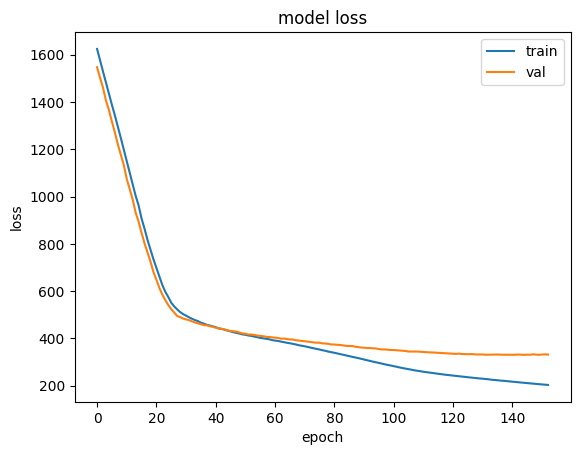

In [73]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [74]:
train_pred = vae_model.predict(train)[0]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


In [75]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}')
error_thresh = np.max(mae_vector) -0.01
print(f'setting threshold on {error_thresh} ')

Avg error 0.17672361433506012
median error 0.16988800466060638
setting threshold on 1.2888460063934326 


(array([ 66., 421., 775., 878., 651., 755., 807., 683., 525., 371., 195.,
        117.,  24.,  18.,   8.,   8.,   7.,   7.,   4.,   1.,   7.,   1.,
          3.,   3.,   3.,   4.,   0.,   3.,   0.,   3.,   1.,   3.,   0.,
          3.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   1.]),
 array([0.02999431, 0.05537135, 0.08074838, 0.10612541, 0.13150245,
        0.15687948, 0.18225652, 0.20763355, 0.23301059, 0.25838763,
        0.28376466, 0.3091417 , 0.33451873, 0.35989577, 0.3852728 ,
        0.41064984, 0.43602684, 0.46140388, 0.48678091, 0.51215798,
        0.53753501, 0.56291205, 0.58828908, 0.61366612, 0.63904315,
        0.66442019, 0.68979722, 0.71517426, 0.74055123, 0.76592827,
        0.7913053 , 0.81668234, 0.84205937, 0.86743641, 0.89281344,
        0.91819048, 0.94356751, 0.96894455, 0.99432158, 1.01969862,
        1.04507565, 1.07045269, 1.09582973, 1.12120676, 1.1465838 ,
        1.17196083, 1.19733787, 1.2227149 , 1.

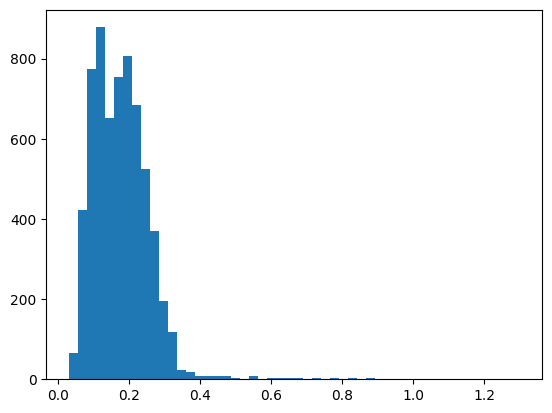

In [76]:
plt.hist(mae_vector, bins=50)

In [77]:
#Actual ratio of anomalies 
ratio=np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.16696363064668274


In [78]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

  1/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step

299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
Avg error 0.34547045826911926
median error 0.32782894372940063


0.0009432973482863432

(array([9.079e+03, 3.260e+02, 8.400e+01, 2.700e+01, 1.000e+01, 6.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.23968542, 0.42241469, 0.60514396, 0.78787327, 0.97060251,
        1.15333176, 1.33606112, 1.51879036, 1.70151961, 1.88424885,
        2.06697822, 2.24970746, 2.4324367 , 2.61516595, 2.79789519,
        2.98062444, 3.16335392, 3.34608316, 3.52881241, 3.71154165,
        3.8942709 , 4.07700014, 4.25972939, 4.44245863, 4.62518787,
        4.80791712, 4.99064636, 5.17

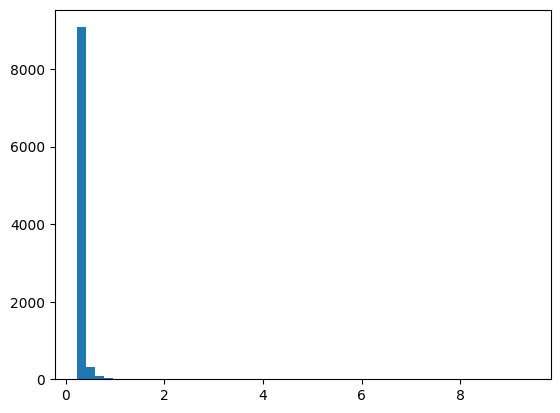

In [79]:
plt.hist(mae_vector_test, bins=50)

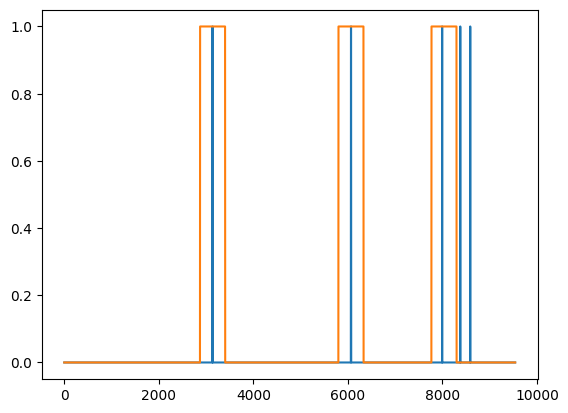

In [80]:
plt.plot(anomalies)
plt.plot(labels_of_test)

In [81]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.17      1.00      0.29      1593
        True       0.22      0.00      0.00      7948

    accuracy                           0.17      9541
   macro avg       0.19      0.50      0.14      9541
weighted avg       0.21      0.17      0.05      9541



In [85]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[: int(len(data) * test_ratio)]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

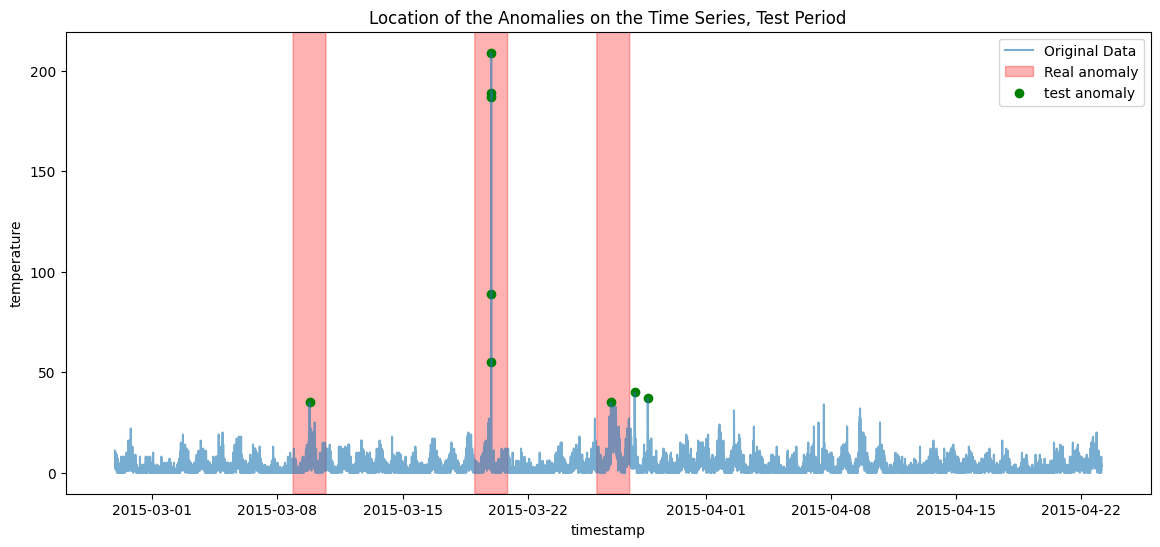

In [86]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==1, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=data_w_ts['label'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Realll anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")